# Population Quality Control and Adjustment


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
import anndata as ad
import scanpy as sc
import scipy
import path_config
from datetime import date
today = date.today()

import warnings
warnings.filterwarnings("ignore")
sb.set_context(context='poster')

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

# set a random seed
np.random.seed(0)


scanpy==1.9.8 anndata==0.9.2 umap==0.5.5 numpy==1.24.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.1.3 statsmodels==0.14.1 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [2]:
output_path = path_config.output_path
input_path = output_path


In [3]:

HIGHLY_VARIABLE_GENES = 10000
condition = 'control'

In [4]:
adata = ad.read_h5ad(os.path.join(input_path , 'campari_scs_'+str(HIGHLY_VARIABLE_GENES)+'_from_R.h5ad'))
adata_all = ad.read_h5ad(os.path.join(input_path , 'campari_scs_all_genes_'+str(HIGHLY_VARIABLE_GENES)+'_from_R.h5ad'))
adata_all_norm = ad.read_h5ad(os.path.join(input_path , 'campari_scs_all_genes_norm_'+str(HIGHLY_VARIABLE_GENES)+'_from_R.h5ad'))

In [5]:
# make names unique
adata.var_names_make_unique()

Filter the adata object to keep only the genes not in the exclusion list

In [6]:

# List of genes to exclude
genes_to_exclude =  ['TdTomato','Cre','Campari','EGFP','mNeptune','ReachR','flp0','iCre','Calm1','rRNA_18s_1870bp'] 
print(f"Before filtering: {adata.shape}")
# Filter the adata object to keep only the genes not in the exclusion list
adata = adata[:, ~adata.var_names.isin(genes_to_exclude)].copy()
print(f"After filtering: {adata.shape}")


Before filtering: (4034, 10000)
After filtering: (4034, 9993)


# Split to control cells and campari cells

In [7]:
x = adata.X
# get stim data (as numbers)
stim = np.zeros((x.shape[0],))
for i in range(x.shape[0]):
    stim[i] = adata.obs['stimulus'][i]
    
## We split the cels between campari and control cells. Control cells == 0
campari_cells = np.logical_and(stim != 0,stim!=0)
control_cells = np.logical_or(stim == 0, stim==0)
campari_cells = np.where(campari_cells)[0]
control_cells = np.where(control_cells)[0]

adata_campari = adata[campari_cells,:]
adata_control = adata[control_cells,:]

print('Number of campari cells = ', len(campari_cells))
print('Number of control cells = ', len(control_cells))

Number of campari cells =  2997
Number of control cells =  1037


Filtered, not normalized and Filtered + normalized and standardized

In [8]:

#### data_all and data_all_norm are also split in order to track the same order or cells later
adata_all_control = adata_all[control_cells,:]
adata_all_campari = adata_all[campari_cells,:]

adata_all_norm_control = adata_all_norm[control_cells,:]
adata_all_norm_campari = adata_all_norm[campari_cells,:]


# Dimentionality reduction
On control data (atlas)

In [9]:
### Dimentionality reduction examples using multiple techniques
### Select one number of componets, for example n = 15 and do louvain
### with that number of componets (manually investigated the optimal number of PC)
N_selected = 24
sc.pp.pca(adata_control, n_comps=N_selected, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_control)
sc.tl.tsne(adata_control)
sc.tl.umap(adata_control)

computing PCA
    on highly variable genes
    with n_comps=24
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 24
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing tSNE
    using 'X_pca' with n_pcs = 24
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


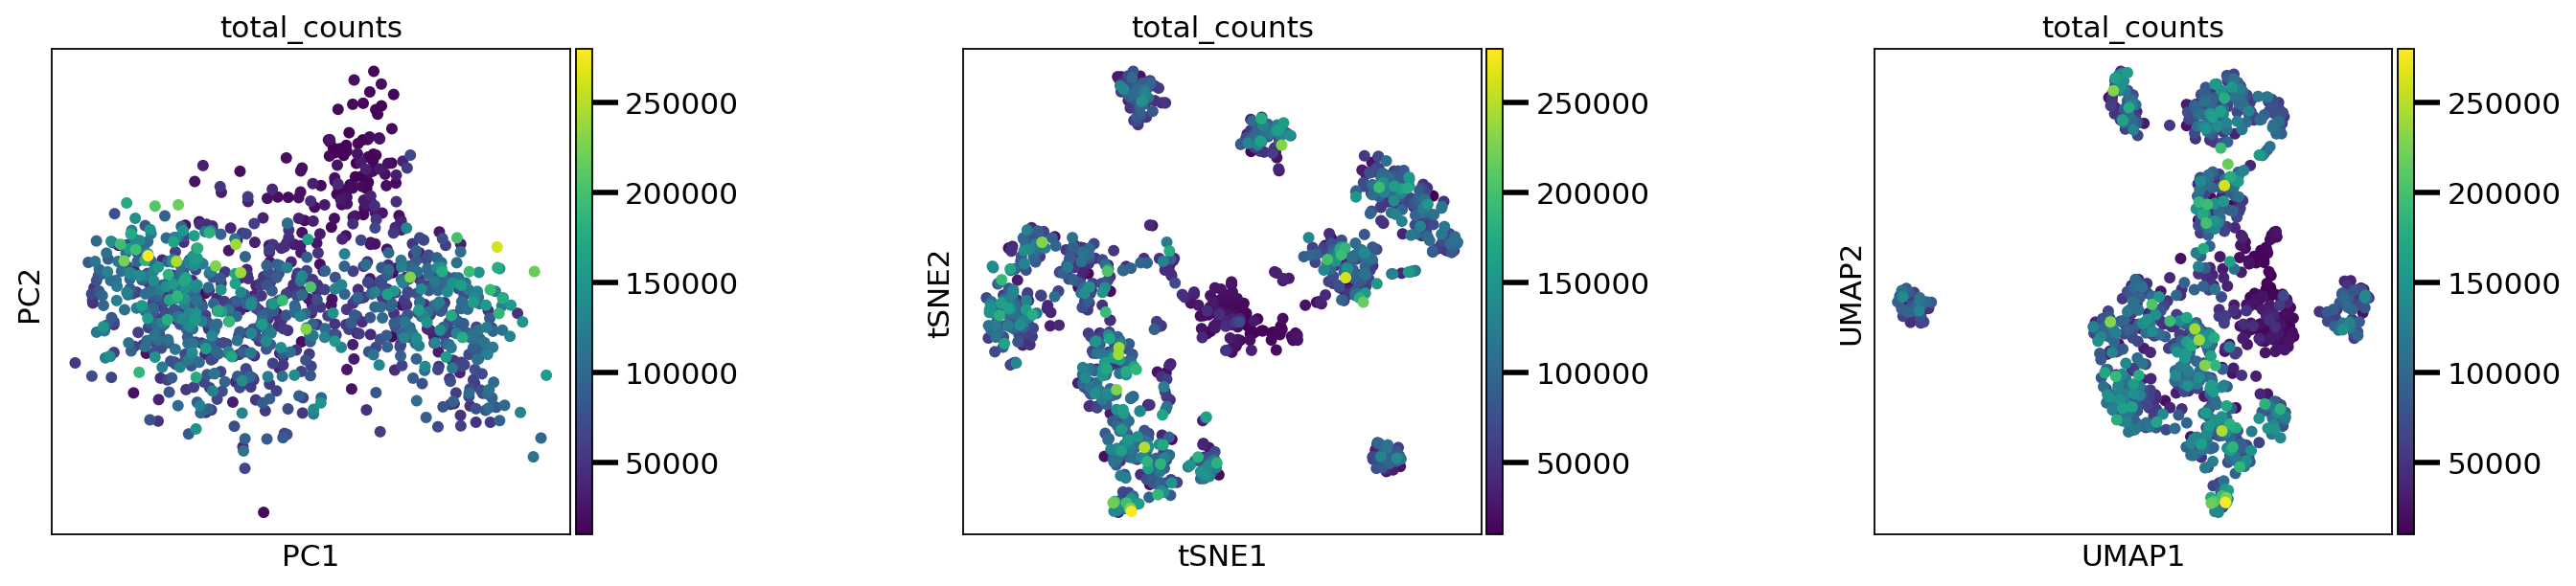

In [10]:
rcParams['figure.figsize']=(20,10)
fig_ind=np.arange(231, 237)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p10 = sc.pl.pca_scatter(adata_control, color='total_counts', ax=fig.add_subplot(fig_ind[0]), show=False)
p11 = sc.pl.tsne(adata_control, color='total_counts', ax=fig.add_subplot(fig_ind[1]), show=False)
p12 = sc.pl.umap(adata_control, color='total_counts', ax=fig.add_subplot(fig_ind[2]), show=False)

# Clustering
On control data (atlas)

In [11]:
# Perform clustering - using highly variable genes 
louvain_paramenters = [3]
louvain_names = []
for value in louvain_paramenters:
    louvain_names.append('louvain_r' + str(value))

for value,name in zip(louvain_paramenters,louvain_names):
    sc.tl.louvain(adata_control, resolution=value, key_added=name)  

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 20 clusters and added
    'louvain_r3', the cluster labels (adata.obs, categorical) (0:00:00)


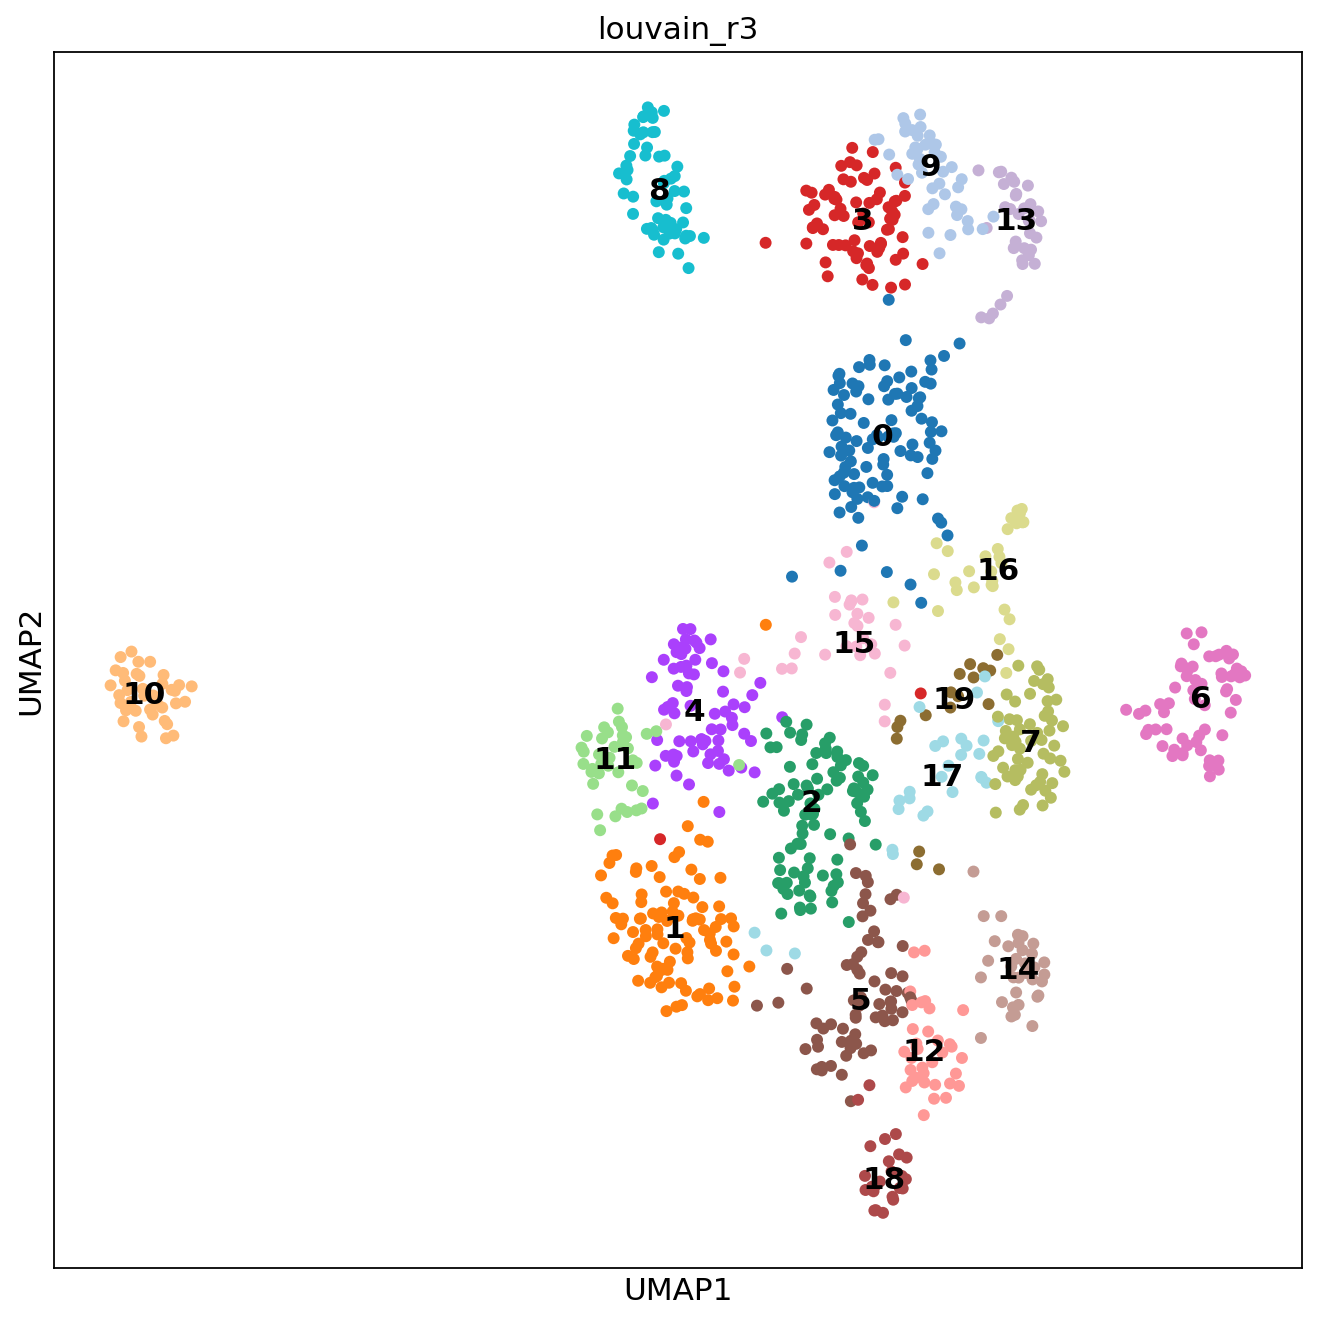

In [12]:
rcParams['figure.figsize']=(10,10)
#Visualize the clustering and how this is reflected by different technical covariates
#for name in louvain_names:
sc.pl.umap(adata_control, color=louvain_names, legend_loc='on data')

In [13]:
for clustering_method in louvain_names:
    ### now we embbed campari cells into the control cluster!
    sc.tl.ingest(adata_campari, adata_control, obs=clustering_method, embedding_method='umap')
    adata_campari.obs['transfered_clusters_'+clustering_method] = adata_campari.obs[clustering_method]
    adata_control.obs['clusters_'+clustering_method] = adata_control.obs[clustering_method]
    
    adata_concat = adata_control.concatenate(adata_campari, batch_categories=["control", "campari"])
    ### data_all and data_all_norm are also concatenated to keep same order
    adata_all_concat = adata_all_control.concatenate(adata_all_campari, batch_categories=["control", "campari"])
    adata_all_norm_concat = adata_all_norm_control.concatenate(adata_all_norm_campari, batch_categories=["control", "campari"])


running ingest
    finished (0:00:20)


In [14]:
adata_concat

AnnData object with n_obs × n_vars = 4034 × 9993
    obs: 'barcode', 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'area', 'cell_id', 'batch', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'louvain_r3', 'clusters_louvain_r3', 'transfered_clusters_louvain_r3'
    var: 'gene_id', 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    obsm: 'X_umap'

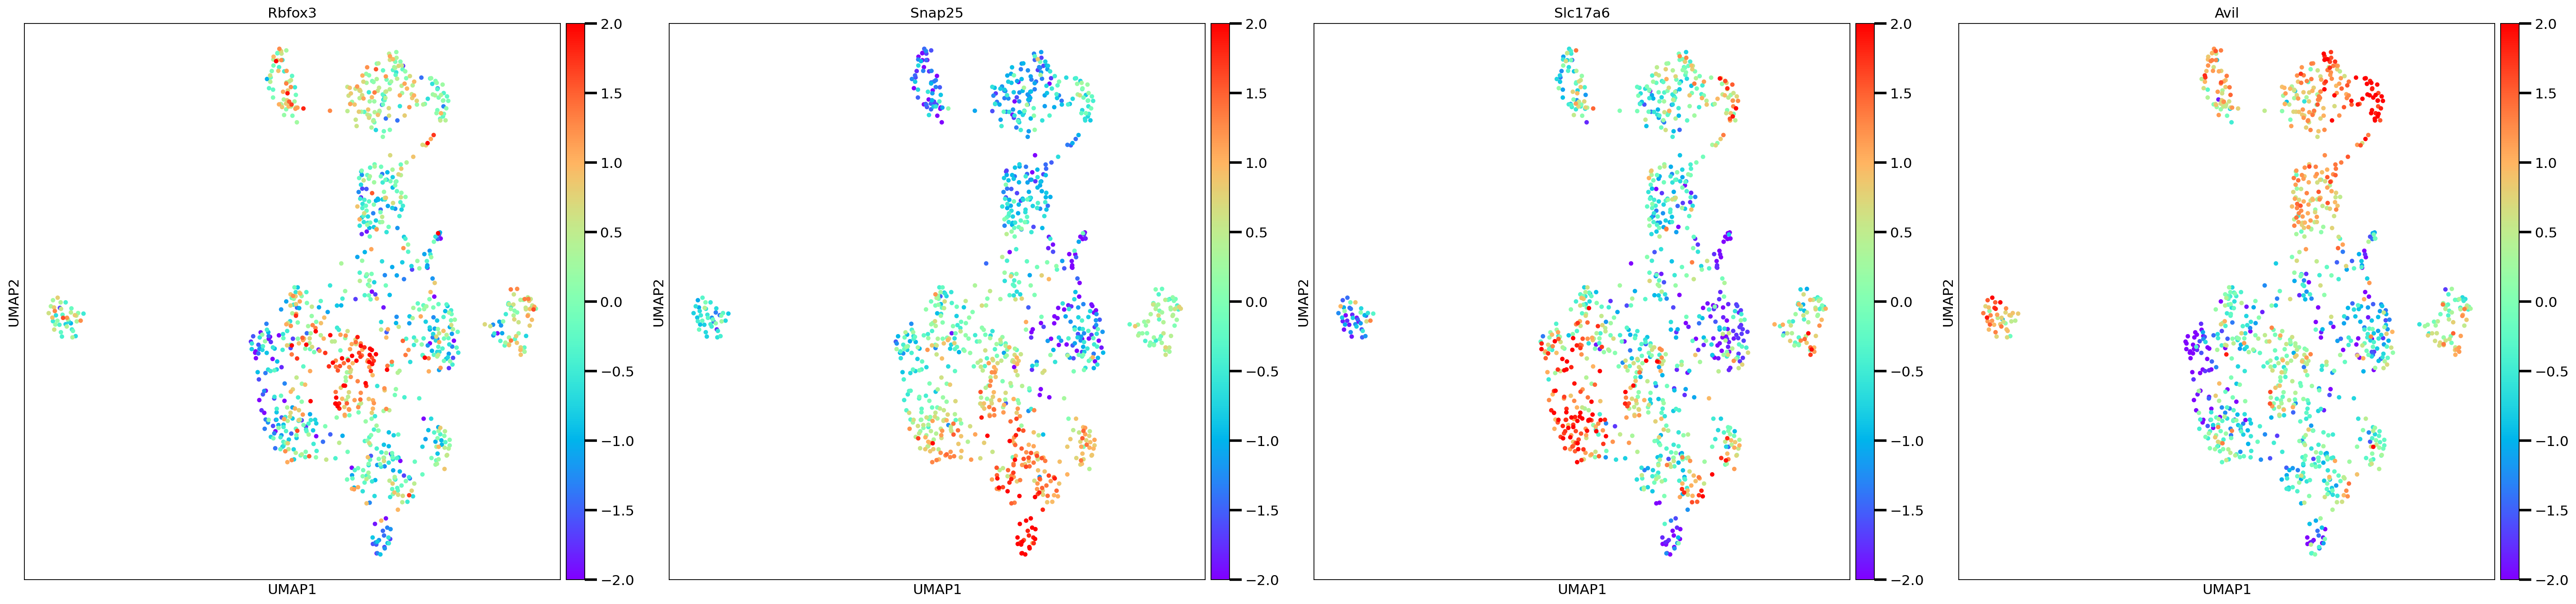

In [15]:
# make names unique
genes_list = []
for i in range(adata_control.shape[1]):
    genes_list.append(adata_control.var['gene_name'][i])
    
genes_of_interest_prior = ['Rbfox3', 'Snap25', 'Eef1a1', 'Slc17a6', 'Avil','Syn1']
genes_of_interest = []
for gene in genes_of_interest_prior:
    if gene in genes_list:
        genes_of_interest.append(gene)

sc.pl.umap(adata=adata_control, color=genes_of_interest, use_raw=False, cmap = 'rainbow',
           size = 80,vmin=-2, vmax=2)

## We choose a clustering method

In [16]:
clustering_method = 'louvain_r3'

## Identify clusters with low expression of sensory neurons markers

In [17]:
# Assuming you have run Louvain and UMAP already
# Your AnnData object is assumed to be `adata`
# List of genes of interest
genes_of_interest_prior = ['Syn1', 'Rbfox3', 'Snap25', 'Eef1a1', 'Slc17a6', 'Avil']
genes_of_interest = []
for gene in genes_of_interest_prior:
    if gene in genes_list:
        genes_of_interest.append(gene)
print(genes_of_interest)

# Calculate the root of the sum of squared values (Euclidean norm) for each gene in all cells
# Convert the sparse matrix to a dense format if necessary and then perform the square and sum
X_dense = adata_all_concat[:, genes_of_interest].X.toarray()  # Convert to dense array
print('X_dense shape' + str(X_dense.shape))

total_expression = np.sqrt(np.square(X_dense).sum(axis=0))/20
print(total_expression.shape)
# Calculate the 5% threshold for each gene
thresholds = {gene: 0.05*total_expression[i] for i, gene in enumerate(genes_of_interest)}

# Print the thresholds for reference
print("Thresholds set to 5% of total expression for each gene:")
for gene, threshold in thresholds.items():
    print(f"{gene}: {threshold}")


# Convert the transformed data back to a DataFrame
transformed_df = pd.DataFrame(X_dense, index=adata_concat.obs_names, columns=genes_of_interest)

# Calculate the mean expression of these genes in each cluster
mean_expression_per_cluster = transformed_df.groupby(adata_concat.obs[clustering_method]).mean()

['Rbfox3', 'Snap25', 'Slc17a6', 'Avil']
X_dense shape(4034, 4)
(4,)
Thresholds set to 5% of total expression for each gene:
Rbfox3: 4.671982983701889
Snap25: 21.43639632727479
Slc17a6: 2.783045768578016
Avil: 9.673840369780763


## Identify clusters of low quality cells (low umi count)

In [18]:
# Filter clusters based on thresholds
print(mean_expression_per_cluster.shape)
#print(mean_expression_per_cluster)
clusters_to_exclude = []
# Iterate through clusters and check if all gene expressions are below the threshold
for cluster in mean_expression_per_cluster.index:
    for gene in genes_of_interest:
        if mean_expression_per_cluster.loc[cluster, gene] <= thresholds[gene]:
            clusters_to_exclude.append(cluster)

clusters_to_exclude = list(set(clusters_to_exclude))
print(f"Clusters to exclude based on low expression neuronal markers: {clusters_to_exclude}")  

# The result is a DataFrame where each row corresponds to a cluster, and each column to a gene of interest
print(clusters_to_exclude)

(20, 4)
Clusters to exclude based on low expression neuronal markers: ['19', '7', '16']
['19', '7', '16']


In [19]:
mean_counts_cluster = adata_control.obs['total_counts'].groupby(adata_control.obs[clustering_method]).mean()
mean_counts_cluster.to_csv(path_or_buf= output_path + '/mean_counts_expression_'+condition + '_'+str(HIGHLY_VARIABLE_GENES)+'.csv')
print(mean_counts_cluster)
thresholds = {'total_counts': 65000 }
#print(mean_counts_cluster)
for cluster in range(len(mean_counts_cluster)):
    if mean_counts_cluster[cluster] <= thresholds['total_counts']:
        clusters_to_exclude.append(str(cluster))
print(list(set(clusters_to_exclude)))

clusters_to_exclude = list(set(clusters_to_exclude))
print(f"Clusters to exclude based on low expression other markers: {clusters_to_exclude}") 

louvain_r3
0      89998.173077
1      93608.775510
2      98131.483146
3      79122.635135
4      72611.557143
5     108871.205882
6      70765.177419
7      21751.120690
8      90560.982456
9      88028.604651
10     70847.333333
11     83902.692308
12     97578.085714
13     82425.882353
14     93870.470588
15     69287.636364
16     17415.600000
17     35953.535714
18    135656.583333
19     30919.388889
Name: total_counts, dtype: float64
['17', '19', '7', '16']
Clusters to exclude based on low expression other markers: ['17', '19', '7', '16']


## Exclude low quality clusters

In [20]:
# Assuming clusters_to_exclude has already been computed from the previous step

# Find the cells that belong to the clusters to exclude
cells_to_exclude = adata_concat.obs[clustering_method].isin(clusters_to_exclude)

# Subset the adata object to exclude those cells
adata_excluded = adata_concat[cells_to_exclude].copy()
adata_filtered = adata_concat[~cells_to_exclude].copy()

### 
adata_all_filtered = adata_all_concat[~cells_to_exclude].copy()
adata_all_norm_filtered = adata_all_norm_concat[~cells_to_exclude].copy()

# Now `adata_filtered` contains only the cells that do not belong to the excluded clusters

print(f"Number of cells before exclusion: {adata_concat.shape[0]}")
print(f"Number of cells after exclusion: {adata_filtered.shape[0]}")


Number of cells before exclusion: 4034
Number of cells after exclusion: 3754


# Excluded and Included cells by plate

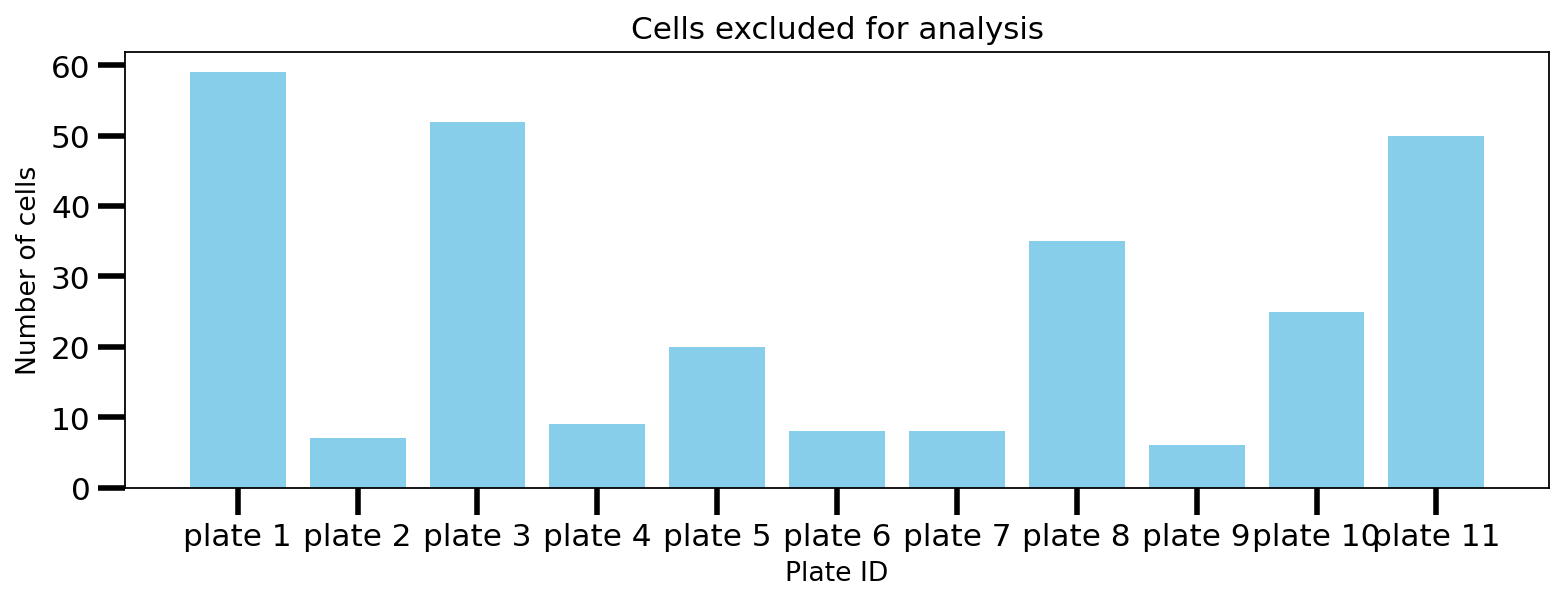

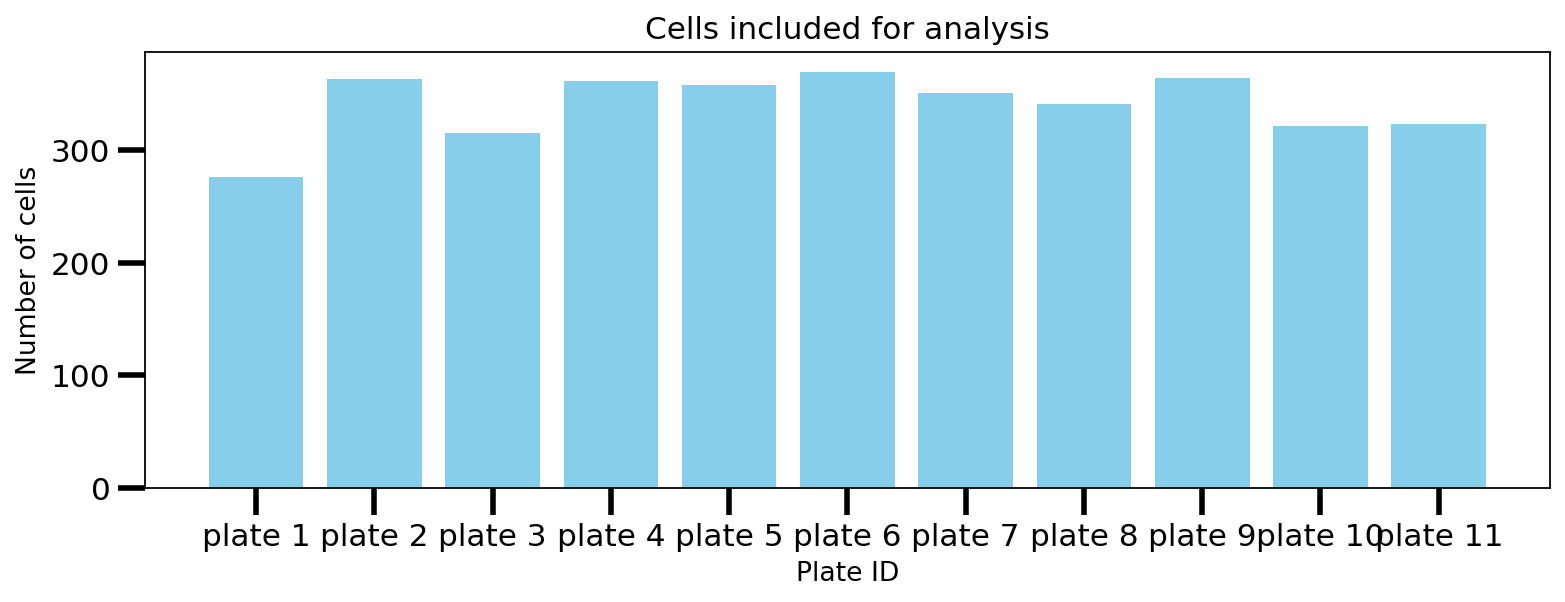

In [21]:
plate_excluded = np.zeros((adata_excluded.shape[0]))
for i in range(adata_excluded.shape[0]):
    plate_excluded[i] = adata_excluded.obs['plate_number'][i]

# Count the frequency of each number
unique, counts = np.unique(plate_excluded, return_counts=True)
# Prepare labels for the x-axis (plate+number)
x_labels = [f'plate {int(num)}' for num in unique]

# Create the bar plot
plt.figure(figsize=(10, 4))
plt.bar(x_labels[1:], counts[1:], color='skyblue')
# Add labels and title
plt.xlabel('Plate ID', fontsize=12)
plt.ylabel('Number of cells', fontsize=12)
plt.title('Cells excluded for analysis', fontsize=14)

# Display the plot
plt.tight_layout()
plt.grid(False)
plt.show()

plate_included = np.zeros((adata_filtered.shape[0]))
for i in range(adata_filtered.shape[0]):
    plate_included[i] = adata_filtered.obs['plate_number'][i]

# Count the frequency of each number
unique, counts = np.unique(plate_included, return_counts=True)
# Prepare labels for the x-axis (plate+number)
x_labels = [f'plate {int(num)}' for num in unique]

# Create the bar plot
plt.figure(figsize=(10, 4))
plt.bar(x_labels[1:], counts[1:], color='skyblue')
# Add labels and title
plt.xlabel('Plate ID', fontsize=12)
plt.ylabel('Number of cells', fontsize=12)
plt.title('Cells included for analysis', fontsize=14)

# Display the plot
plt.tight_layout()
plt.grid(False)
plt.show()


# Export adata objects

In [ ]:
adata_filtered.write_h5ad(
    os.path.join(output_path , 'campari_scs_umap_cells_'+condition + '_'+str(HIGHLY_VARIABLE_GENES)+'_excluded.h5ad'),
)
adata_all_filtered.write_h5ad(
    os.path.join(output_path , 'campari_scs_umap_all_cells_'+condition + '_'+str(HIGHLY_VARIABLE_GENES)+'_excluded.h5ad'),
)

adata_all_norm_filtered.write_h5ad(
    os.path.join(output_path , 'campari_scs_umap_all_norm_cells_'+condition + '_'+str(HIGHLY_VARIABLE_GENES)+'_excluded.h5ad'),
)

: 